# Classification

The classification solution tries to address the problem:

*Train a learning model that assigns each expense transaction to one of the set of predefined categories and evaluate it against the validation data provided. The set of categories are those found in the "category" column in the training data. Report on accuracy and at least one other performance metric.*

For this, my approach is to first load the data, do a bit of exploratory analysis, and then apply several classifiers (Logistic Regression, Naive Bayes, SVM, XGBoost, Random Forest) on the data, so performance evaluation and see which (or a combination of which) performs the best. We will try ensembling several classifiers since ensembles are known to perform better in general.

## Necessary imports

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import itertools

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix

## Load data from CSV to pandas dataframes

In [2]:
df_train = pd.read_csv('training_data_example.csv')
df_val = pd.read_csv('validation_data_example.csv')
df_employee = pd.read_csv('employee.csv')

In [3]:
df_employee['city'] = df_employee['employee address'].apply(lambda x: x.split(',')[1])

# Preprocessing and Observations for feature engineering

We will join Employee data with both Training and Validation data separately to get possibly useful information from the Employee data set. Some useful observations:

- **Role** and **Address** are useful information in Employee. We can extract the **city** information from the address, however the **tax name** informtion already contains province/country so we can do with that. 
- **date** is a useful information. However, it will possibly be better if we extract the **month** and **day of week** from the day. It's possible that people have certain expending habits on certain months or on certain days of weeks (like weekends).
- Perhaps the most useful piece of data for tackling this problem is the **expense description** field. Intuitively, an expense category should have the biggest correlation with this field than any other field, however, thata ssumption is not necessarily true in practice.
- **expense description** is a free form text field whereas all other fields are numerical/categorical. So it makes sense to vectorize and analyze this field separately and later combine with other features.

So we will first exclude the **expense description** field from our preprocessing step, and vectorize the rest of the useful fields, which are:

- day_of_week
- month
- employee id
- pre-tax amount
- role

As part of this we will also **one-hot encode** the categorical variables (the ones other than **pre-tax amount**)

Also, since pre-tax amount is a real valued continuous variable, we will scale it to 0-1 as a means of feature normalization, to avoid any bias in classification for this large valued field.

Let's define a method for preprocessing.

In [4]:
def pre_process(df, columns_to_drop=['date',
                                    'category', 
                                    'tax amount',                                  
                                    'expense description']):
    
    df['day_of_week'] = pd.to_datetime(df['date']).apply(lambda x: x.weekday()).astype(str) # str so that treated as categoical
    df['month'] = pd.to_datetime(df['date']).apply(lambda x: x.month).astype(str)
    df = pd.merge(df, df_employee[['employee id', 'role']], how='inner', on=['employee id'])
    df['employee id'] = df['employee id'].astype(str)
    df = df.drop(columns_to_drop, axis=1)
    
    # one-hot encode the categorical variables
    df = pd.get_dummies(df)
    
    df['pre-tax amount'] = preprocessing.minmax_scale(df[['pre-tax amount']])
    
    return df

Now obtain the preprocessed training and validation data and and fix any alignment issues and missing values in the validation data.

In [5]:
x_train = pre_process(df_train)
x_val = pre_process(df_val)
x_train, x_val = x_train.align(x_val, join='left', axis=1)
x_val = x_val.fillna(0)

In [6]:
x_val.head()

,pre-tax amount,employee id_1,employee id_3,employee id_4,employee id_5,employee id_6,employee id_7,tax name_CA Sales tax,tax name_NY Sales tax,day_of_week_0,...,day_of_week_5,day_of_week_6,month_10,month_11,month_12,month_9,role_CEO,role_Engineer,role_IT and Admin,role_Sales
0,0.004514,0,0.0,0,0.0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0.0,1
1,0.055918,1,0.0,0,0.0,0,0,1,0,0,...,1,0,0,1,0,0,1,0,0.0,0
2,0.047141,1,0.0,0,0.0,0,0,1,0,1,...,0,0,0,1,0,0,1,0,0.0,0
3,1.000000,0,0.0,1,0.0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0.0,1
4,0.002006,0,0.0,1,0.0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0.0,1


Now for the text field **expense description**, we vectorize it using **TFIdfVectorizer**. Although the vectorizer provides a sparse matrix, we densify it so that we can merge it to the non-text features based vectorized data obtained previously.

In [7]:
vectorizer = TfidfVectorizer(stop_words='english')
vectorizer.fit(df_train['expense description'])
x_train_tfidf = vectorizer.transform(df_train['expense description']).toarray()
x_val_tfidf = vectorizer.transform(df_val['expense description']).toarray()

Now concatenate the text and non-text features to get the final vectorized datasets.

In [8]:
x_train = np.concatenate((x_train.values, x_train_tfidf), axis=1)
x_val = np.concatenate((x_val.values, x_val_tfidf), axis=1)

Now labelize the **categories** of the training and validation data.

In [9]:
lencoder = LabelEncoder()
lencoder.fit(df_train['category'])
names = set(df_val['category']) # label names to be used later
y_train = lencoder.transform(df_train['category'])
y_val = lencoder.transform(df_val['category'])
val_categoroes = []
for clazz in lencoder.classes_:
    if clazz in names:
        val_categoroes.append(clazz)
lencoder.classes_

array(['Computer - Hardware', 'Computer - Software',
       'Meals and Entertainment', 'Office Supplies', 'Travel'], dtype=object)

## Observation on the category distribution and possible performatce metric

Interestingly, it turns out that the distribution of the **category** variable is not even. It's pretty skewed as is evident from the flowwing figure. The distrbution is largely dominated by **Meals and Entertainment** followed by others, which is an indication that **accuracy** alone is not going to be a reliable performance metric. We will compute **precision**, **recall** and **f1 score** mesurements on the result.

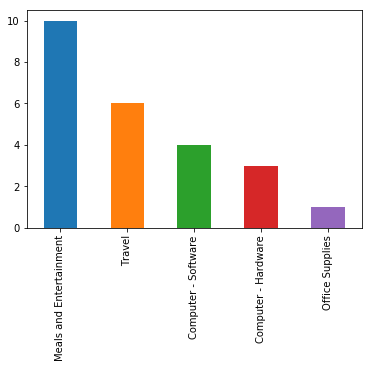

In [10]:
f = pd.value_counts(df_train['category']).plot.bar()

So now that we have the vectorized features ready, it's time to train and evaluate performance.

## Model fitting and evaluation

Our plan is to try out the following classifiers and then ensemble them at the end if possible:
- Logistic Regression
- Multinomial Naive Bayes
- SVM
- Gradient Boosting (XGBoost)
- Random Forest

For each of these, we will try out fitting the models on the training set in a two fold approach - with and without **cross validation**. Also, as mentioned earlier, since the **expense description** field is intuitively the most expressive field, we will be fitting the models in 2 ways - all features and only the text features. So overall, we will be fitting each model 4 times:
- All features and no cross validation
- All features with cross validation
- Only text features and no cross validation
- Only text features with cross validation

And finally will be taking the one of these that performs best on the validation data. Since the datasets are small, we will be using **Leave one out** cross validation. For cross validation purpose, we will be using **GridSearchCV** to try out different combinations of parameters. (These combinations are not exhaustive, of course, I will only try out a few)

Let's define a general purpose method that can fitting and scoring for the above 4 scenarios.

In [11]:
def evaluate(model, x_train, y_train, x_val, y_val, cross_validate=False, grid_search_params={}):
    if cross_validate:
        grid_search_model = GridSearchCV(estimator=model,
                                          cv=LeaveOneOut(),
                                          param_grid=grid_search_params, 
                                          verbose=0)
        grid_search_model.fit(x_train, y_train)
        return (grid_search_model.best_estimator_.score(x_train, y_train),
                grid_search_model.best_estimator_.score(x_val, y_val),
                grid_search_model.best_estimator_.predict(x_val),
                grid_search_model.best_estimator_)
    else:
        model.fit(x_train, y_train)
        return (model.score(x_train, y_train), model.score(x_val, y_val), model.predict(x_val), 0)   

Now let's define the set of models along with the parameter combinations that will be used for grid search. The paramter combinations I am using for different models are:
- LogicticRegression
    - C (Regularization factor)
- MultinomialNB
    - alpha (Regularization factor)
- SVM
    - C (Regularization factor)
- XGBoost
    - max depth
    - Learning rate
    - subsample (Subsample ratio of the training instance.)
    - colsample_bytree (Subsample ratio of columns when constructing each tree)
    - reg_alpha (L1 regularization term on weights)
- Random Forest
    - n_estimators (number of trees)

In [12]:
models = [
     {
        'name': 'LogisticRegression',
        'model': LogisticRegression(),
        'grid_search_params': {'C':[2,1,0.5]}
     },
     {
        'name': 'MultinomialNB',
        'model': MultinomialNB(),
        'grid_search_params': {'alpha':[2,1,0.5]} 
     },
     {
        'name': 'SVM',
        'model': svm.SVC(kernel='linear', random_state=1),
        'grid_search_params': {'C':[2,1,0.5]} 
     },
     {
        'name': 'XGBoost',
        'model': XGBClassifier(objective='multi:softmax', 
                               num_class=len(set(y_train)),
                               random_state=1),
        'grid_search_params': {'max_depth': [3,5,7],
                               'learning_rate': [0.001,0.01,0.1],
                               'subsample':[0.5,1],
                               'colsample_bytree':[0.5,0.7,1],
                               'reg_alpha':[0,1,2]
                             }
     },
     {
        'name': 'RandomForest',
        'model': RandomForestClassifier(n_estimators=50, random_state=1),
        'grid_search_params': {'n_estimators': [10,25,50,100,200,300]}
     }
]

Let's fit and evaluate all the models and see the results

In [13]:
scores = []
predictions = []
for model in models:
    model['scores'] = []
    model['predictions'] = []
    
    print('{}\n'.format(model['name']))
    score_train, score_val, predictions, estimator = evaluate(model['model'], x_train, y_train, x_val, y_val)
    model['scores'].append(score_val) 
    model['predictions'].append(predictions) 
    print('Training score with all features and no cross validation: {}'.format(score_train))
    print('Validation score with all features and no cross validation: {}'.format(score_val))
    score_train, score_val, predictions, estimator = evaluate(model['model'], x_train, y_train, x_val, y_val, 
                                cross_validate=True, grid_search_params=model['grid_search_params'])
    model['scores'].append(score_val) 
    model['predictions'].append(predictions) 
    print('Training score with all features and cross validation: {}'.format(score_train))
    print('Validation score with all features and cross validation: {}'.format(score_val))
    
    score_train, score_val, predictions, estimator = evaluate(model['model'], x_train_tfidf, y_train, x_val_tfidf, y_val)
    model['scores'].append(score_val) 
    model['predictions'].append(predictions) 
    print('Training score with only text (description) feature and no cross validation: {}'.format(score_train))
    print('Validation score with only text (description) feature and no cross validation: {}'.format(score_val))
    score_train, score_val, predictions, estimator = evaluate(model['model'], x_train_tfidf, y_train, x_val_tfidf, y_val, 
                                cross_validate=True, grid_search_params=model['grid_search_params'])
    model['scores'].append(score_val) 
    model['predictions'].append(predictions) 
    print('Training score with only text (description) feature and cross validation: {}'.format(score_train))
    print('Validation score with only text (description) feature and cross validation: {}\n'.format(score_val))
    
    model['best_prediction'] = model['predictions'][np.argmax(model['scores'])]

LogisticRegression

Training score with all features and no cross validation: 1.0
Validation score with all features and no cross validation: 0.75
Training score with all features and cross validation: 1.0
Validation score with all features and cross validation: 0.8333333333333334
Training score with only text (description) feature and no cross validation: 0.9583333333333334
Validation score with only text (description) feature and no cross validation: 0.8333333333333334
Training score with only text (description) feature and cross validation: 1.0
Validation score with only text (description) feature and cross validation: 0.9166666666666666

MultinomialNB

Training score with all features and no cross validation: 0.9166666666666666
Validation score with all features and no cross validation: 0.75
Training score with all features and cross validation: 0.9166666666666666
Validation score with all features and cross validation: 0.75
Training score with only text (description) feature and n

Let's print out the best predictions for each model.

In [14]:
for model in models:
    print(model['name'])
    print('Best score:' + str(np.max(model['scores']))) 
    print('Best predictions: ' + str(model['best_prediction']))

LogisticRegression
Best score:0.916666666667
Best predictions: [4 2 0 3 2 4 2 2 2 2 2 2]
MultinomialNB
Best score:0.833333333333
Best predictions: [4 2 0 2 2 4 2 2 2 2 2 2]
SVM
Best score:0.916666666667
Best predictions: [4 2 0 3 2 4 2 2 2 2 2 2]
XGBoost
Best score:0.666666666667
Best predictions: [4 2 4 0 4 4 4 2 2 2 2 2]
RandomForest
Best score:0.916666666667
Best predictions: [4 2 0 3 2 4 2 2 2 2 2 2]


## Some observations here

From the above results, it looks like that except for XGBoost, all other classifiers are performing better using only the test features rather than all features. With Random forest, SVM and Logistic Regression, the training accuracy is 100% and the validation accuracy is 91.67%. With XGBoost (a bit surprisengly to me), while the training accuracy is 100% (using all features and no cross validation), the validation accuracy achieved is only 66.67%. (This is something that deserves further investigation and tuning for sure)

## Ensemble
Let's try an ensemble of Random forest, SVM and Logistic Regression predictions to get our final predictions.

In [15]:
def ensemble(preds):
    def mode(vals):
        counts = dict(Counter(vals))
        return sorted(counts.items(), key=lambda x: (x[1], x[0]), reverse=True)[0][0]
        
    preds = np.vstack(preds)
    return np.apply_along_axis(mode, 0, preds)

In [16]:
ensemble_result = ensemble([models[0]['best_prediction'],
                            models[2]['best_prediction'],
                            models[4]['best_prediction']])

ensemble_accuracy = np.sum(ensemble_result == y_val) / len(y_val)
print('Ensemble accuracy: {}'.format(ensemble_accuracy))

Ensemble accuracy: 0.9166666666666666


So the ensemble accuracy is no better that the individual models' accuracy, and that's based on the fact that each of those 3 models were unable to identify the correct category for the same single data point, which is the fifth data point in the validation set, where the actual category is **Office Supplies** but it has been classified as **Meals and Entertainment**.

Let's get the precision, recall and f1-score:

In [17]:
print(classification_report(y_val, ensemble_result, target_names=val_categoroes))

                         precision    recall  f1-score   support

    Computer - Hardware       1.00      1.00      1.00         1
Meals and Entertainment       0.88      1.00      0.93         7
        Office Supplies       1.00      0.50      0.67         2
                 Travel       1.00      1.00      1.00         2

            avg / total       0.93      0.92      0.91        12



Because of the misclassification of the one data point, the recall on the **Office Supplies** is only 0.5 (since there are only 2 data points in this category), and the precision of **Meals and Entertainment** is also lowered to 0.88. However, overall, we seem to have a decent precision and recall of 93% and 92%, respectively.

Let's also visualize the confusion matrix, which just conveys the same information a bit more pictorially.

In [18]:
# This method is just copied from a scikit learn documentation example
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1 0 0 0]
 [0 7 0 0]
 [0 1 1 0]
 [0 0 0 2]]


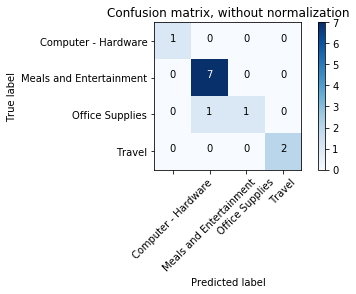

In [19]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val, ensemble_result)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=val_categoroes,
                      title='Confusion matrix, without normalization')

## Conclusion

We have tried several approches for classification with crss-validation and grid-searching, and also tried an ensemble of a few approaches. A few takeaway points for myself:

- I had anticipated XGBoost to perform much better. I was quite surprised it didn't. Probably that will be acievable with some further parameter tuning and better feature generation, and more importantly with more data. I am relatively new to XGBoost so I need further insight into this

- All classifiers were unable to predict one data point correctly. Even the ensemble didnt help. Probably an indication that better tuning and feature engineering is more necessary that ensembling different approaches.

- I have tried to define a general approach of configuring models and parameters and then run them through a generic method, which I believe, could be handy. I have separation of concern in mind and hence I separated the pre-processing, vectorization and prediction steps, and the made the prediction step customizable using configurable models and parameters

- Most of the classifiers were at least as good with only text features as with all features.

- Random Forest, Logistic regression and SVM all performed pretty well.

**Most importantly**

**Since there were not enough data, with a bigger dataset, it is possible that these behaviour might change. I have learnt from my experience that models performing well on smaller data are not becessary the best models for real world data with massive size.** 


My personal preference is to go with ensemble approaches like **Random Forest** and **XGBoost** (although XGBoost didn't perform here as well as expected as pointed out previously), since they have the power of learning from an ensemble of different classifiers (trees), rather than relying on the type of kernel (as in SVM). Also, Scikit learn's Random forest and XGBoost implementation provides a lot of parameters to tune the classifiers.

In the Spark based bonus solution, I will try the **Random forest** approach.